#### Name: Sumanasekara W.K.G.G.
#### index: 190610E

In [39]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

file_path = "templeSparseRing/"

Importing the data

In [40]:
f = open(file_path+"templeSR_par.txt", 'r')
assert f is not None

n = int(f.readline())
im_fn, K, R, t= [], [], [], []

for _ in range(2):
    l = f.readline().split()
    im_fn.append(l[0])
    K.append(np.array([float(i) for i in l[1: 10]]).reshape(3, 3))
    R.append(np.array([float(i) for i in l[10: 19]]).reshape(3, 3))
    t.append(np.array([float(i) for i in l[19: 22]]).reshape(3, 1))

im = [cv.imread(file_path+name, cv.IMREAD_COLOR) for name in im_fn]
P = [K[i] @ np.hstack((R[i], t[i])) for i in range(2)]

SIFT features and matches

In [41]:
sift = cv.xfeatures2d.SIFT_create()
kp1, desc1 = sift.detectAndCompute(im[0], None)
kp2, desc2 = sift.detectAndCompute(im[1], None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k=2)

good, pts1, pts2 = [], [], []

for i,  (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1, pts2 = np.array(pts1), np.array(pts2)

Fundamental matrix 

In [42]:
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
F

array([[ 1.49034037e-06,  1.44154168e-05, -2.53948320e-02],
       [-8.25788252e-06,  8.67005344e-08,  4.00767127e-03],
       [ 2.27526901e-02, -7.28270380e-03,  1.00000000e+00]])

Essential matrix

In [43]:
E = K[1].T @ F @ K[0]
E

array([[ 3.44509489e+00,  3.34434549e+01, -3.25145725e+01],
       [-1.91581088e+01,  2.01870994e-01,  2.33852108e+00],
       [ 3.21786978e+01, -4.43004055e+00, -6.22266684e-03]])

Pose of the second camera with respect to the first

In [44]:
retval, R2_, t2_, mask = cv.recoverPose(E, pts1, pts2, K[0])

In [45]:
# Rotation matrix of second camera with respect to the first one
R2_

array([[ 0.99735986, -0.06955966,  0.02085083],
       [ 0.06147285,  0.96159443,  0.26750185],
       [-0.03865738, -0.26551385,  0.96333172]])

In [46]:
# Translation matrix of second camera with respect to the first one
t2_

array([[-0.06179206],
       [-0.86049654],
       [-0.50569501]])

Second camera matrix

In [47]:
R2 = R[0] @ R2_
t2 = R[0] @ t2_
R_T_2 = np.concatenate((R2, t2), axis=1)
P2 = K[1] @ R_T_2
P2

array([[ 1.58524669e+02,  1.53324446e+03, -1.64453374e+02,
        -9.53099575e+02],
       [ 1.53407871e+03, -1.25194936e+02, -1.42282633e+02,
         4.27897189e+01],
       [ 7.55162306e-02,  8.27859886e-02, -9.93702057e-01,
         6.49896959e-01]])

3-D point locations

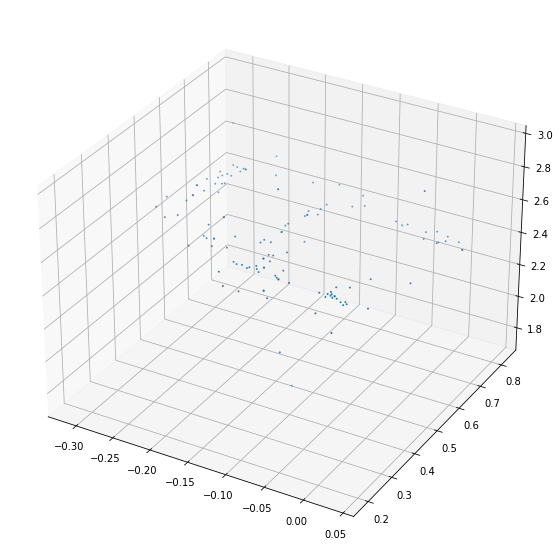

In [48]:
points4d = cv.triangulatePoints(P[0], P2, pts1.T, pts2.T)
points4d /= points4d[3, :]

fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(points4d[0, :], points4d[1, :], points4d[2, :], s=1, cmap='gray')
plt.show()